# Analysis of Malaria (2000 - 2017)

---

Malaria is an acute febrile illness caused by Plasmodium parasites, which are spread to people through the bites of infected female Anopheles mosquitoes.

In this project we generate useful summaries and meaningful visualization that answer the following questions:

1. What is the year-on-year trend of malaria cases, deaths and death rates
2. Which regions have the highest number of cases, deaths and death rates combined
3. Which countries in Africa have the highest cases combined
4. Which countries in Western Pacific have the highest death rates in the whole period.

In addition, a linear model for the number of deaths given the number of cases globally, is created

## Required packages

We collect the required Python packages for the analysis.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.image as image
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
import utils

## The data

We have copied the data to the project directory from where Python will read the data into a dataframe named malaria.

We preview 10 random samples of malaria

In [2]:
data_dir = os.path.join('resources', 'data', 'malaria.csv')
malaria = pd.read_csv(data_dir)
malaria.sample(10)

,Country,Year,No. of cases,No. of deaths,WHO Region
968,United Republic of Tanzania,2009.0,211.0,16776.0,Africa
1046,Nigeria,2008.0,143079.0,8677.0,Africa
1114,Ecuador,2007.0,8464.0,8.0,Americas
1661,Gabon,2002.0,62976.0,1141.0,Africa
439,Argentina,2013.0,0.0,0.0,Americas
1768,Ethiopia,2001.0,392377.0,1681.0,Africa
501,Myanmar,2013.0,333871.0,236.0,South-East Asia
634,Suriname,2012.0,356.0,0.0,Americas
1185,Uzbekistan,2007.0,30.0,1.0,Europe
1146,Mexico,2007.0,2361.0,0.0,Americas


We also view the technical information for malaria

In [3]:
malaria.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1948 entries, 0 to 1947
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Country        1947 non-null   object 
 1   Year           1946 non-null   float64
 2   No. of cases   1712 non-null   float64
 3   No. of deaths  1676 non-null   float64
 4   WHO Region     1945 non-null   object 
dtypes: float64(3), object(2)
memory usage: 76.2+ KB


From the technical information, there are a number of issues we should address during data cleaning

- Style of column names
- Records with missing values
- Style for textual values
- Data types for the columns

# Data cleaning

---

- Style of column names: We use simple column names with lower case.
- Records with missing values: If year or country is missing for a record, that record is useless anyway. In addition , we remove records for which cases or deaths are missing. Finally, we remove records with missing region.
- Style for textual values: We adopt a lower case for textual values.
- Ensure correct data types.

In [4]:
# Rename columns
malaria = malaria.rename(columns=utils.clean_name)

# Remove all records for which country or year are not available
malaria = malaria.dropna(axis=0, subset=['country', 'year'])

# Remove all records for which cases or deaths are not available
malaria = malaria.dropna(axis=0, subset=['cases', 'deaths'])
malaria = malaria.dropna(axis=0, subset=['region'])

# All textual values must use lower case
malaria['country'] = malaria['country'].str.lower()
malaria['region'] = malaria['region'].str.lower()

# Apply appropriate data types
malaria = malaria.astype({'country': 'str'})
malaria = malaria.astype({'region': 'str'})
malaria['year'] = malaria['year'].astype('int')
malaria['year'] = malaria['year'].astype('str')

---

The missing values we have removed is just a special case of inconsistecies we must address. Generally, we must ensure the data is consistent with a number of expectations

- A record must have row level completeness otherwise we must remove it.
- Deaths cannot be greater than cases: We have to remove such records
- Duplicates: Only one record per year is allowed for each country. We must remove duplicates if any.
- A country can only belong to one region: Are there any countries that belong to two or more regions?
- Records with both cases and deaths equal to 0 should be removed.
- New index should be created

In [5]:
# Expectation: deaths cannot be greater than cases
consistent = (malaria['cases'] >= malaria['deaths']).all()
consistent
# Remove all inconsistent records
malaria = malaria.loc[(malaria['cases'] >= malaria['deaths']), :]
# Review inconsistencies
consistent = (malaria['cases'] >= malaria['deaths']).all()
consistent

# Expectation: no country can provide records more than once in a year
duplicates = malaria.duplicated(subset=['country', 'year']).sum()
if duplicates > 0:
    malaria = malaria.dropduplicates(subset=['country', 'year'])

# Expectation: no country can appear in two regions
countries = malaria['country'].unique()
regions = malaria['region'].unique()
for country in countries:
    placeholder = []
    for region in regions:
        ls = list(malaria[malaria['region'] == region]['country'].unique())
        if country in ls:
            placeholder.append(region)
            if len(placeholder) == 2:
                print(country, ': ', placeholder)

# Records with both cases and deaths equal to 0 should be removed
malaria = malaria.drop(malaria[(malaria['cases'] == 0) & (malaria['deaths'] == 0)].index)

# Create new index
malaria.index = range(malaria.shape[0])

# Review data

---

## Review tecnical information

- View technical information of malaria

In [6]:
malaria.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1429 entries, 0 to 1428
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  1429 non-null   object 
 1   year     1429 non-null   object 
 2   cases    1429 non-null   float64
 3   deaths   1429 non-null   float64
 4   region   1429 non-null   object 
dtypes: float64(2), object(3)
memory usage: 55.9+ KB


## Review columns

- Unique values in country
- Unique values in region
- Unique values in year

In [7]:
# Unique values in country
countries = malaria['country'].unique()
print('Countries: ', list(countries))

# Unique values in region
regions = malaria['region'].unique()
print('Regions: ', list(regions))

# Unique values in year
years = malaria['year'].unique()
print('Years: ', list(years))


Countries:  ['afghanistan', 'angola', 'bangladesh', 'belize', 'benin', 'bhutan', 'bolivia (plurinational state of)', 'botswana', 'brazil', 'burkina faso', 'burundi', 'cabo verde', 'cambodia', 'cameroon', 'central african republic', 'chad', 'colombia', 'comoros', 'congo', 'costa rica', "cote d'ivoire", "democratic people's republic of korea", 'democratic republic of the congo', 'dominican republic', 'ecuador', 'eritrea', 'eswatini', 'ethiopia', 'gabon', 'gambia', 'ghana', 'guatemala', 'guinea', 'guinea-bissau', 'guyana', 'haiti', 'honduras', 'india', 'indonesia', 'iran (islamic republic of)', "lao people's democratic republic", 'madagascar', 'malawi', 'malaysia', 'mali', 'mauritania', 'mexico', 'mozambique', 'myanmar', 'namibia', 'nepal', 'niger', 'pakistan', 'panama', 'papua new guinea', 'peru', 'philippines', 'republic of korea', 'rwanda', 'sao tome and principe', 'saudi arabia', 'senegal', 'sierra leone', 'solomon islands', 'somalia', 'south africa', 'south sudan', 'sudan', 'suriname

We have reached a milestone! The data is looking good and ready for exploration.

# Exploratory Analysis

---

## Descriptive summary

In [8]:
malaria.describe()

,cases,deaths
count,1.429000e+03,1429.000000
mean,4.334723e+05,974.005598
std,1.312156e+06,3118.328544
min,1.000000e+00,0.000000
25%,1.974000e+03,1.000000
50%,2.189500e+04,30.000000
75%,1.827680e+05,558.000000
max,1.533084e+07,39054.000000


## Visualization

Set up output and styles of data visualization

In [9]:
mpl.use('nbAgg')
%matplotlib inline
style = './resources/styles/stephen_born.mplstyle'

### Distribution of cases

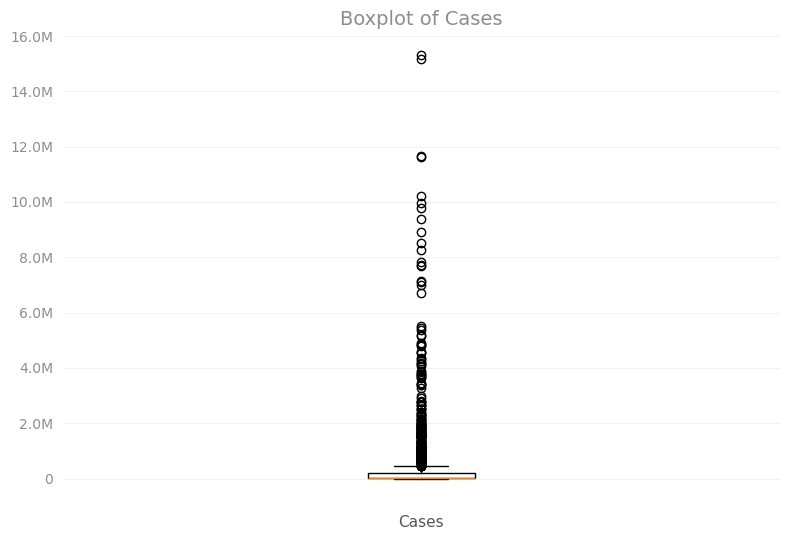

In [10]:
# Are there outliers in cases?
with mpl.style.context(style):
    fig, ax = plt.subplots()
    ax.boxplot(x=malaria['cases'])  # Some outliers
    ax.set(
        title="Boxplot of Cases",
        xlabel='Cases',
        xticklabels=''
    )
    ax.yaxis.set_major_formatter(utils.num_text)
    ax.grid(which='major', axis='x')

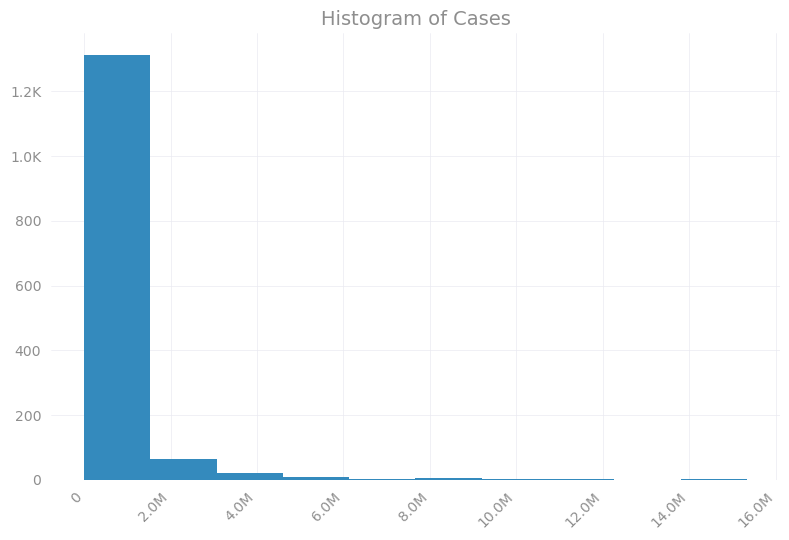

In [11]:
# Frequency distribution of cases
with mpl.style.context(style):
    fig, ax = plt.subplots()
    ax.hist(x=malaria['cases'], bins=10)
    ax.set(
        title="Histogram of Cases"
    )
    ax.xaxis.set_major_formatter(utils.num_text)
    ax.yaxis.set_major_formatter(utils.num_text)
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

- Cases are right skewed and not normally distributed.
- Some cases are disproportionately too large in comparison with most

### Distribution of deaths

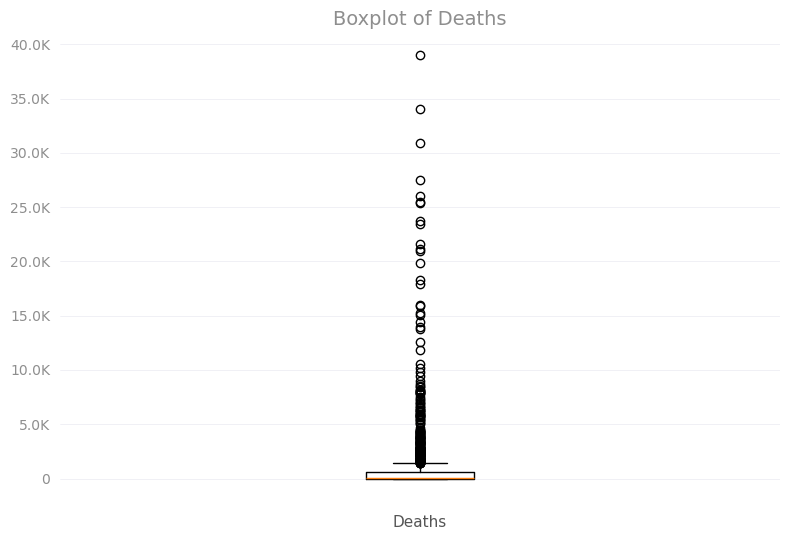

In [12]:
# Are there outliers in deaths?
with mpl.style.context(style):
    fig, ax = plt.subplots()
    ax.boxplot(x=malaria['deaths'])  # Some outliers
    ax.set(
        title="Boxplot of Deaths",
        xlabel='Deaths',
        xticklabels=''
    )
    ax.yaxis.set_major_formatter(utils.num_text)
    ax.grid(which='major', axis='x')

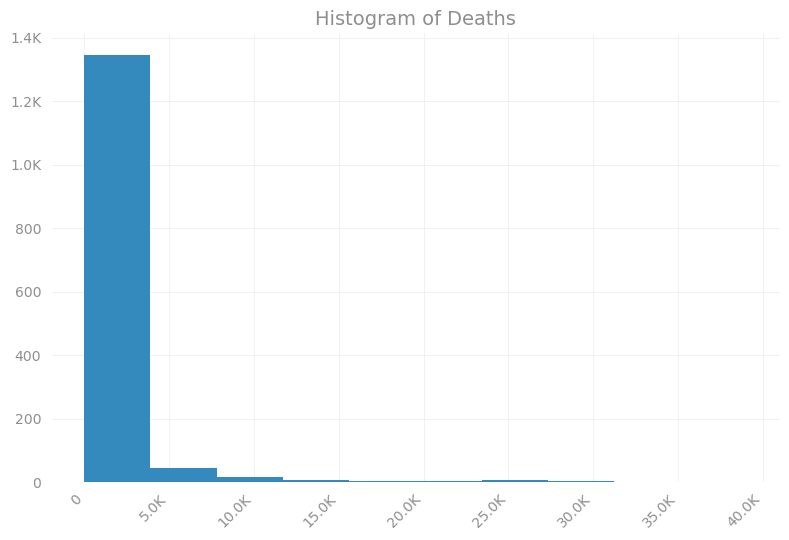

In [13]:
# Frequency distribution of deaths
with mpl.style.context(style):
    fig, ax = plt.subplots()
    ax.hist(x=malaria['deaths'], bins=10)  # Right skewed
    ax.set(
        title="Histogram of Deaths"
    )
    ax.xaxis.set_major_formatter(utils.num_text)
    ax.yaxis.set_major_formatter(utils.num_text)
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

- Deaths are right skewed and not normally distributed.
- Some deaths are disproportionately too large in comparison with most

### Relationship between cases and deaths

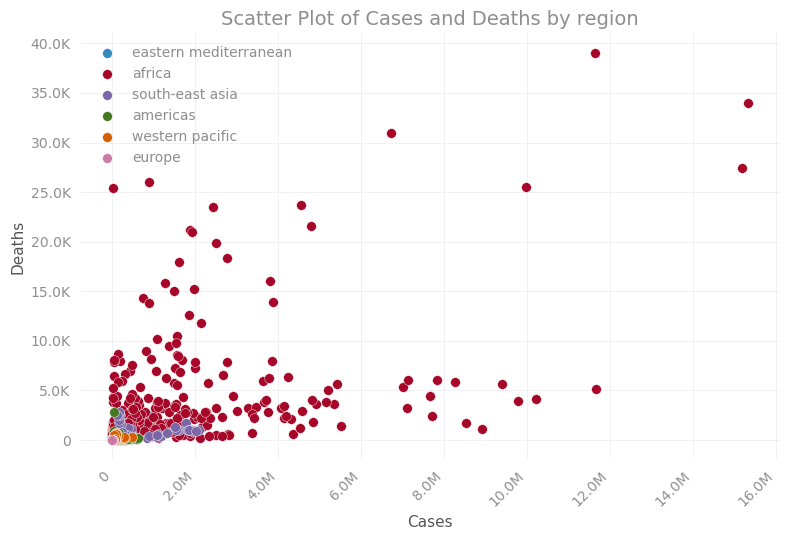

In [14]:
# Relationships: cases vs deaths by region
with mpl.style.context(style):
    fig, ax = plt.subplots()
    for item in malaria['region'].unique():
        ax.scatter(
            x=malaria[malaria['region'] == item]['cases'],
            y=malaria[malaria['region'] == item]['deaths'],
            label=item
        )
    ax.set(
        title="Scatter Plot of Cases and Deaths by region",
        xlabel='Cases',
        ylabel='Deaths'
    )
    ax.xaxis.set_major_formatter(utils.num_text)
    ax.yaxis.set_major_formatter(utils.num_text)
    ax.legend()
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


There seem to be a positive relationship between cases and deaths which could be explored further

# Questions

---

## Question 1: What is the trend of malaria cases, deaths and death rates

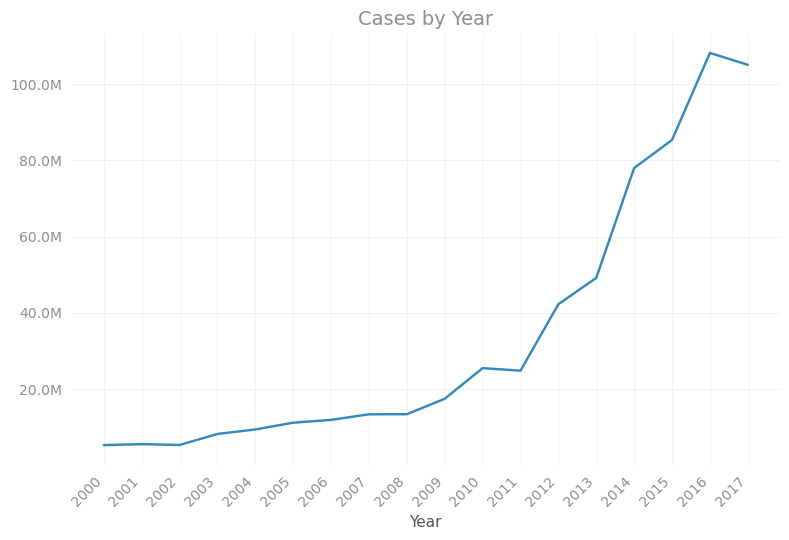

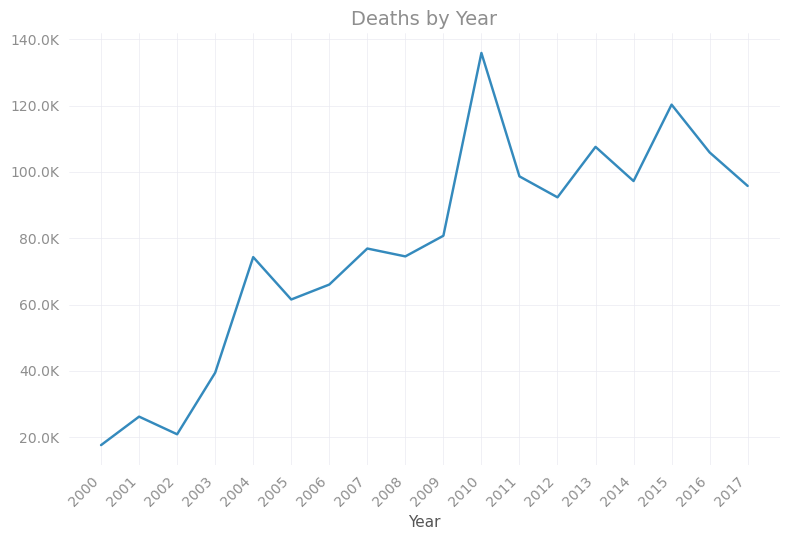

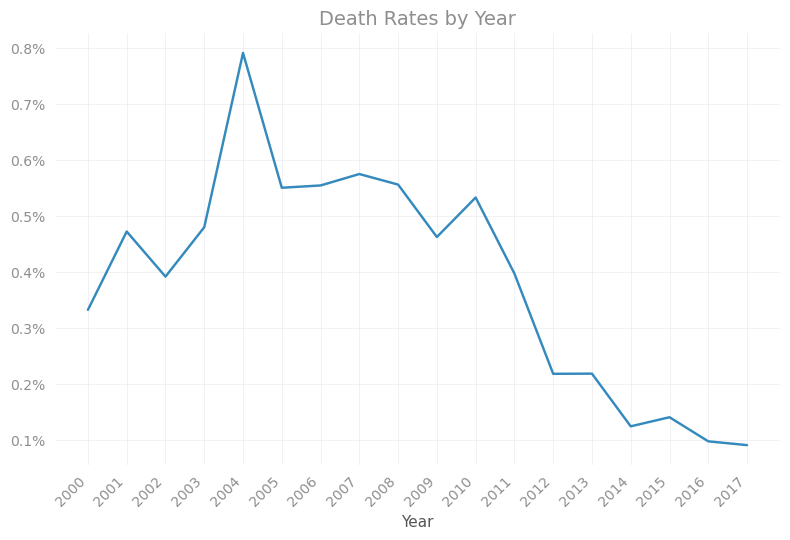

In [15]:
malaria_by_year = malaria.groupby(by='year').sum()
malaria_by_year = malaria_by_year.reset_index()
malaria_by_year['death_rates'] = (malaria_by_year['deaths'] / malaria_by_year['cases']) * 100

# Cases by Year
with mpl.style.context(style):
    fig, ax = plt.subplots()
    ax.plot(malaria_by_year['year'], malaria_by_year['cases'])
    ax.set(
        title="Cases by Year",
        xlabel='Year',
    )
    ax.yaxis.set_major_formatter(utils.num_text)
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Deaths by Year
with mpl.style.context(style):
    fig, ax = plt.subplots()
    ax.plot(malaria_by_year['year'], malaria_by_year['deaths'])
    ax.set(
        title="Deaths by Year",
        xlabel='Year',
    )
    ax.yaxis.set_major_formatter(utils.num_text)
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Death Rates by Year
with mpl.style.context(style):
    fig, ax = plt.subplots()
    ax.plot(malaria_by_year['year'], malaria_by_year['death_rates'])
    ax.set(
        title="Death Rates by Year",
        xlabel='Year',
    )
    ax.yaxis.set_major_formatter(utils.num_cent)
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

**Question 1 Conclusion:** Although cases are on the rise, death rates are decreasing since year 2004

## Question 2: Which regions have the highest number of cases, deaths and death rates combined

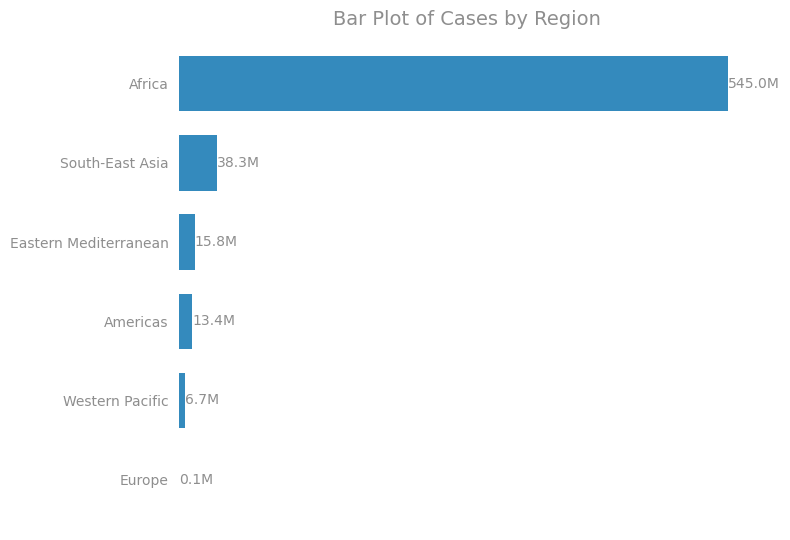

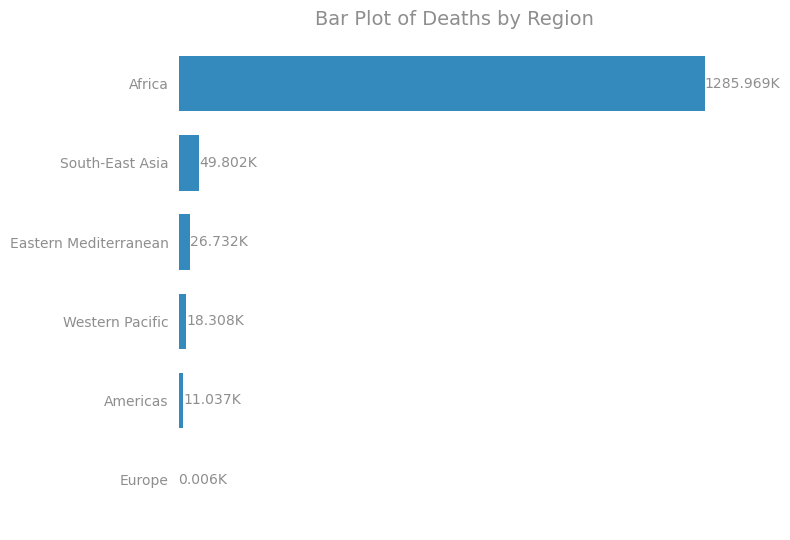

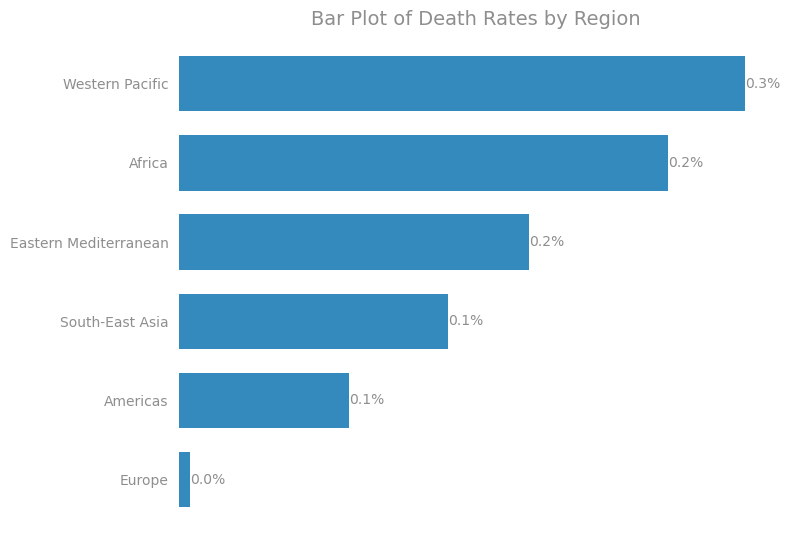

In [16]:
malaria_by_region = malaria.groupby(by='region').sum()
malaria_by_region = malaria_by_region.reset_index()
malaria_by_region['death_rates'] = (malaria_by_region['deaths'] / malaria_by_region['cases']) * 100

# Bar Plot of Cases by Region
malaria_by_region = malaria_by_region.sort_values(by='cases', ascending=True)
with mpl.style.context(style):
    fig, ax = plt.subplots()
    b = ax.barh(y=malaria_by_region['region'].str.title(), width=malaria_by_region['cases']*1e-6, height=.7)
    ax.set(
        title="Bar Plot of Cases by Region",
        xlabel='',
        ylabel='',
        xticklabels=''
    )
    ax.bar_label(b, fmt='%.1fM')
    ax.grid(visible=False)

malaria_by_region = malaria_by_region.sort_values(by='deaths', ascending=True)
with mpl.style.context(style):
    fig, ax = plt.subplots()
    b = ax.barh(y=malaria_by_region['region'].str.title(), width=malaria_by_region['deaths']*1e-3, height=.7)
    ax.set(
        title="Bar Plot of Deaths by Region",
        xlabel='',
        ylabel='',
        xticklabels=''
    )
    ax.bar_label(b, fmt='%.3fK')
    ax.grid(visible=False)

malaria_by_region = malaria_by_region.sort_values(by='death_rates', ascending=True)
with mpl.style.context(style):
    fig, ax = plt.subplots()
    b = ax.barh(y=malaria_by_region['region'].str.title(), width=malaria_by_region['death_rates'], height=.7)
    ax.set(
        title="Bar Plot of Death Rates by Region",
        xlabel='',
        ylabel='',
        xticklabels=''
    )
    ax.bar_label(b, fmt='%.1f%%')
    ax.grid(visible=False)

**Question 2 Concussion:** Africa has the highest number of cases combined but Eastern Pacific has the highest death rates combined

## Question 3: Which countries in Africa have the highest cases combined

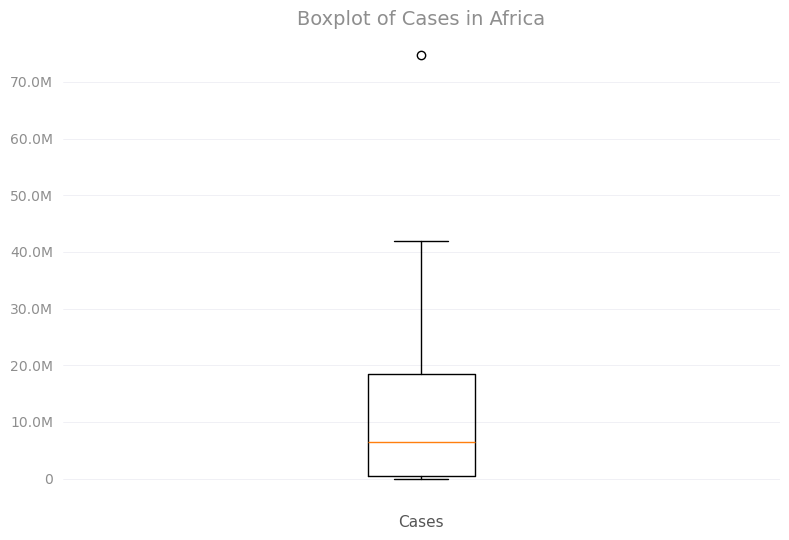

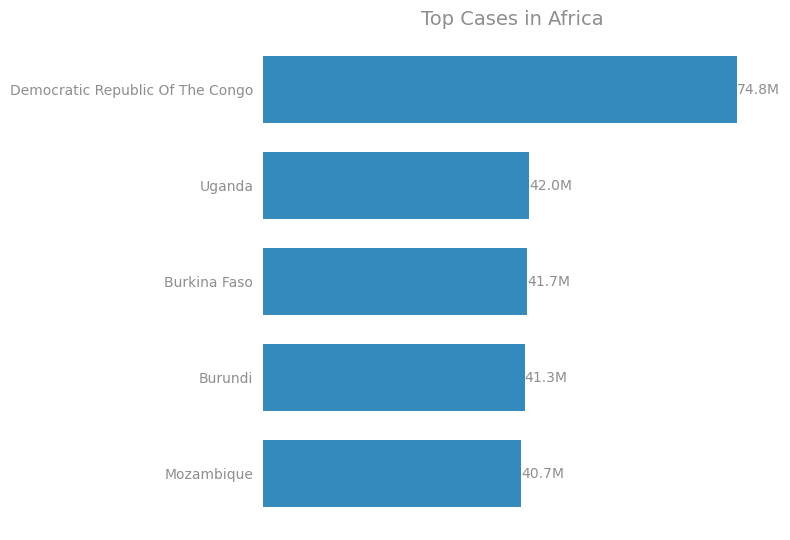

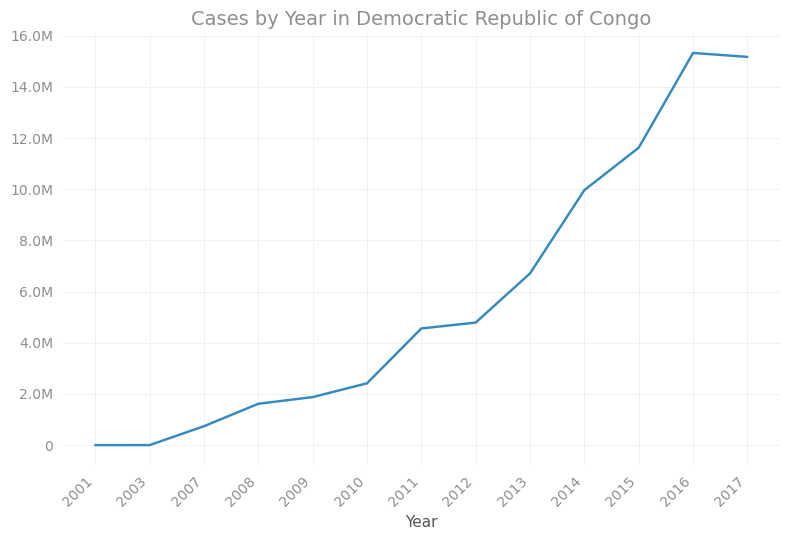

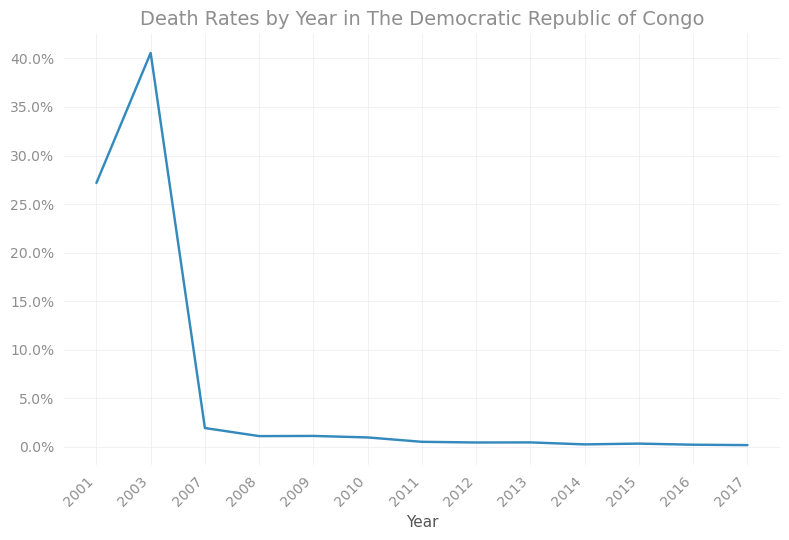

In [17]:
africa = malaria[malaria['region'] == 'africa'].groupby(by='country').sum()
africa = africa.reset_index()
africa['death_rates'] = (africa['deaths'] / africa['cases']) * 100

# Distribution of Cases in Africa
with mpl.style.context(style):
    fig, ax = plt.subplots()
    ax.boxplot(x=africa['cases'])  # Some outliers
    ax.set(
        title="Boxplot of Cases in Africa",
        xlabel='Cases',
        xticklabels=''
    )
    ax.yaxis.set_major_formatter(utils.num_text)
    ax.grid(which='major', axis='x')

# Top combine cases in Africa
africa_top = africa.sort_values(by='cases', ascending=True).tail()
with mpl.style.context(style):
    fig, ax = plt.subplots()
    b = ax.barh(y=africa_top['country'].str.title(), width=africa_top['cases']*1e-6, height=.7)
    ax.set(
        title="Top Cases in Africa",
        xlabel='',
        ylabel='',
        xticklabels=''
    )
    ax.bar_label(b, fmt='%.1fM')
    ax.grid(visible=False)

# Combine cases by year in Democratic Republic of Congo
drc = malaria[malaria['country'] == 'democratic republic of the congo'].sort_values(by=['year'])
with mpl.style.context(style):
    fig, ax = plt.subplots()
    ax.plot(drc['year'], drc['cases'])
    ax.set(
        title="Cases by Year in Democratic Republic of Congo",
        xlabel='Year',
    )
    ax.yaxis.set_major_formatter(utils.num_text)
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Death rates by year in Democratic Republic of Congo
drc['death_rates'] = (drc['deaths'] / drc['cases']) * 100
with mpl.style.context(style):
    fig, ax = plt.subplots()
    ax.plot(drc['year'], drc['death_rates'])
    ax.set(
        title="Death Rates by Year in The Democratic Republic of Congo",
        xlabel='Year',
    )
    ax.yaxis.set_major_formatter(utils.num_cent)
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

**Question 3 conclusion:** Democratic Republic of the Congo has the highest number of cases in Africa and cases there continue to rise

## Question 4: which countries in Western Pacific have the highest death rates in the whole period

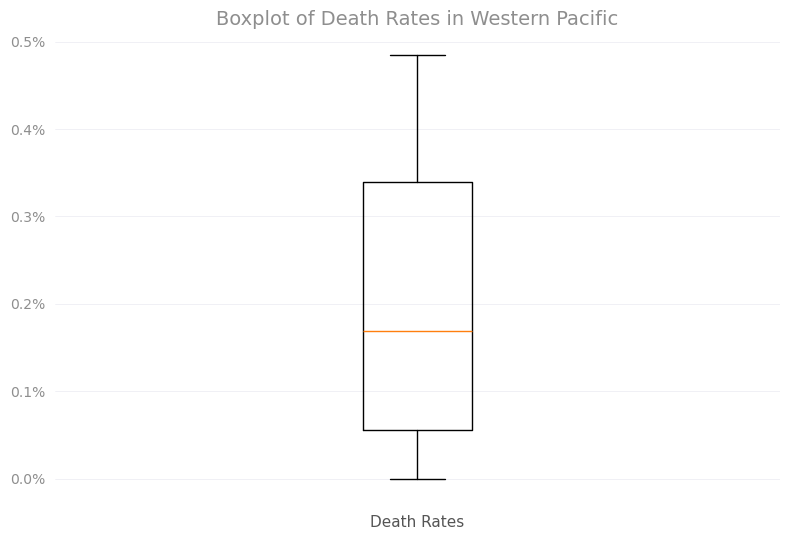

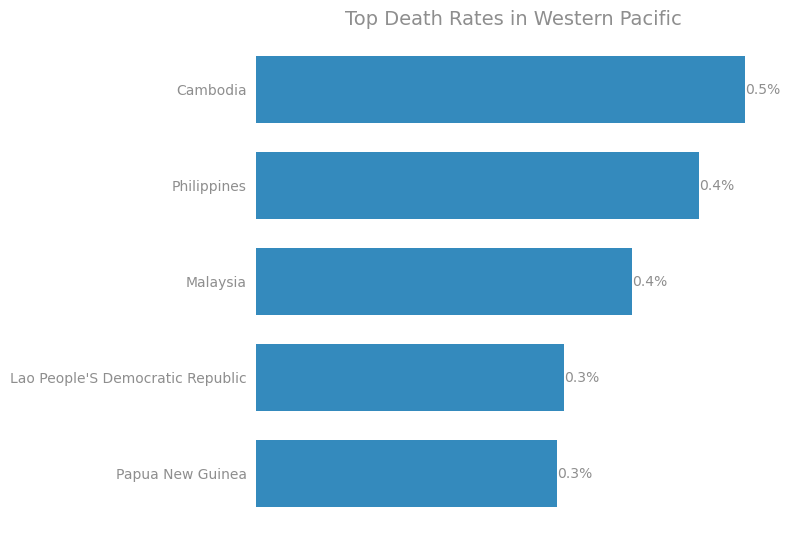

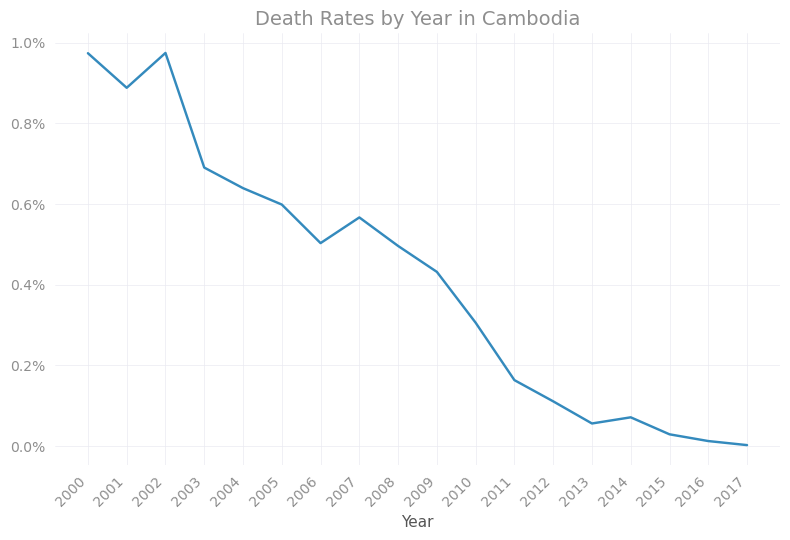

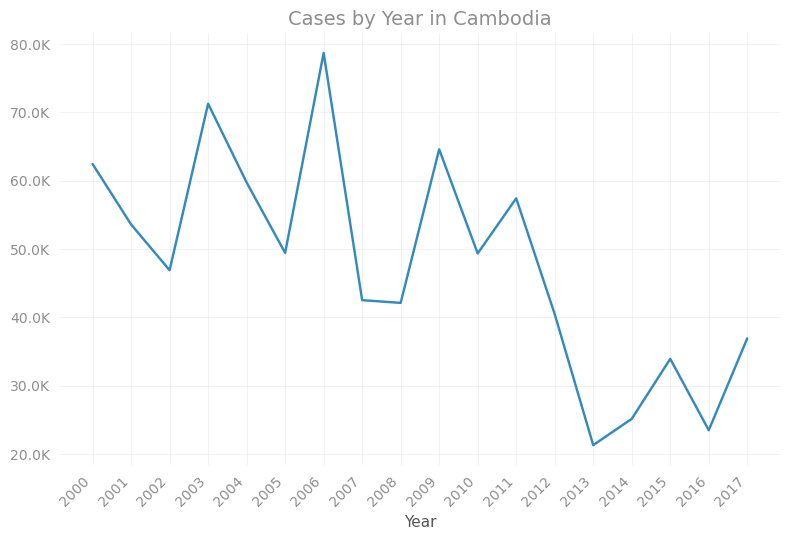

In [18]:
western_pacific = malaria[malaria['region'] == 'western pacific'].groupby(by='country').sum()
western_pacific['death_rates'] = (western_pacific['deaths'] / western_pacific['cases']) * 100
western_pacific = western_pacific.reset_index()

# Distribution of death rates in Western Pacific
with mpl.style.context(style):
    fig, ax = plt.subplots()
    ax.boxplot(x=western_pacific['death_rates'])  # Some outliers
    ax.set(
        title="Boxplot of Death Rates in Western Pacific",
        xlabel='Death Rates',
        xticklabels=''
    )
    ax.yaxis.set_major_formatter(utils.num_cent)
    ax.grid(which='major', axis='x')

# Top Death Rates in Western Pacific
western_pacific_topdr = western_pacific.sort_values(by=['death_rates'], ascending=True).tail()
with mpl.style.context(style):
    fig, ax = plt.subplots()
    b = ax.barh(
        y=western_pacific_topdr['country'].str.title(),
        width=western_pacific_topdr['death_rates'], height=.7
    )
    ax.set(
        title="Top Death Rates in Western Pacific",
        xlabel='',
        ylabel='',
        xticklabels=''
    )
    ax.bar_label(b, fmt='%.1f%%')
    ax.grid(visible=False)

# Death Rates by year in Cambodia
cambodia = malaria[malaria['country'] == 'cambodia'].sort_values(by='year')
cambodia['death_rates'] = (cambodia['deaths'] / cambodia['cases']) * 100
with mpl.style.context(style):
    fig, ax = plt.subplots()
    ax.plot(cambodia['year'], cambodia['death_rates'])
    ax.set(
        title="Death Rates by Year in Cambodia",
        xlabel='Year',
    )
    ax.yaxis.set_major_formatter(utils.num_cent)
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Cases by year in Cambodia
with mpl.style.context(style):
    fig, ax = plt.subplots()
    ax.plot(cambodia['year'], cambodia['cases'])
    ax.set(
        title="Cases by Year in Cambodia",
        xlabel='Year',
    )
    ax.yaxis.set_major_formatter(utils.num_text)
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

**Question 4 Conclusion:** Cambodia has the highest death rates in Western Pacific

## Linear Model

A linear regression model that predict number of deaths given number of cases by region

In [19]:
malaria

,country,year,cases,deaths,region
0,afghanistan,2017,161778.0,10.0,eastern mediterranean
1,angola,2017,3874892.0,13967.0,africa
2,bangladesh,2017,4893.0,13.0,south-east asia
3,belize,2017,7.0,0.0,americas
4,benin,2017,1573163.0,2182.0,africa
...,...,...,...,...,...
1424,united republic of tanzania,2000,17734.0,379.0,africa
1425,uzbekistan,2000,126.0,0.0,europe
1426,vanuatu,2000,6768.0,3.0,western pacific
1427,venezuela (bolivarian republic of),2000,29736.0,24.0,americas


In [22]:
model= smf.ols(formula='deaths ~ cases -1', data=malaria)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 deaths   R-squared (uncentered):                   0.409
Model:                            OLS   Adj. R-squared (uncentered):              0.409
Method:                 Least Squares   F-statistic:                              987.9
Date:                Mon, 29 Apr 2024   Prob (F-statistic):                   2.98e-165
Time:                        15:41:04   Log-Likelihood:                         -13214.
No. Observations:                1429   AIC:                                  2.643e+04
Df Residuals:                    1428   BIC:                                  2.644e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cases          0.0015   4.81e-05     31.431      0.000       0.001       0.002
==============================================================================
Omnibus:                     1332.445   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            78074.296
Skew:                           4.186   Prob(JB):                         0.00
Kurtosis:                      38.230   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the result, the linear model is given by deaths = 0.0015*cases.
Interpretation: On average, a death occurs for every increase by 0.15% of malaria cases globally and this model explains only 40.9% of the variance in the data.

# Conclussion

---

Although malaria cases are on the increase globally, the corresponding death rates are on the decline. 
The highest number of malaria cases and deaths are in Africa but the death rate in Africa is second to the Western Pacific.
In the western Pacific, Cambodia has the highest death rate but even there, death rates have been decreasing over the years.

# Limitation

---

The **Prevalence rate of malaria** is a better indicator for meaningful comparison between countries but computing it requires data on the population of the countries for each of the years considered (2000 - 2017). Unfortunately, the data on population of the countries are not available for this analysis.

# Recommendation

---

There are various sources of data on population of countriesthat could be sourced to enrich this analysis with the important indicators such as **prevalence rate, and mortality rate**.